### Introduction ###

This notebook is heavily inspired by Keras's transfer learning tutorial. This notebook adresses a fundemental problem of identifying worn tires. An image of a cracked tire and healthy tire are shown below. 

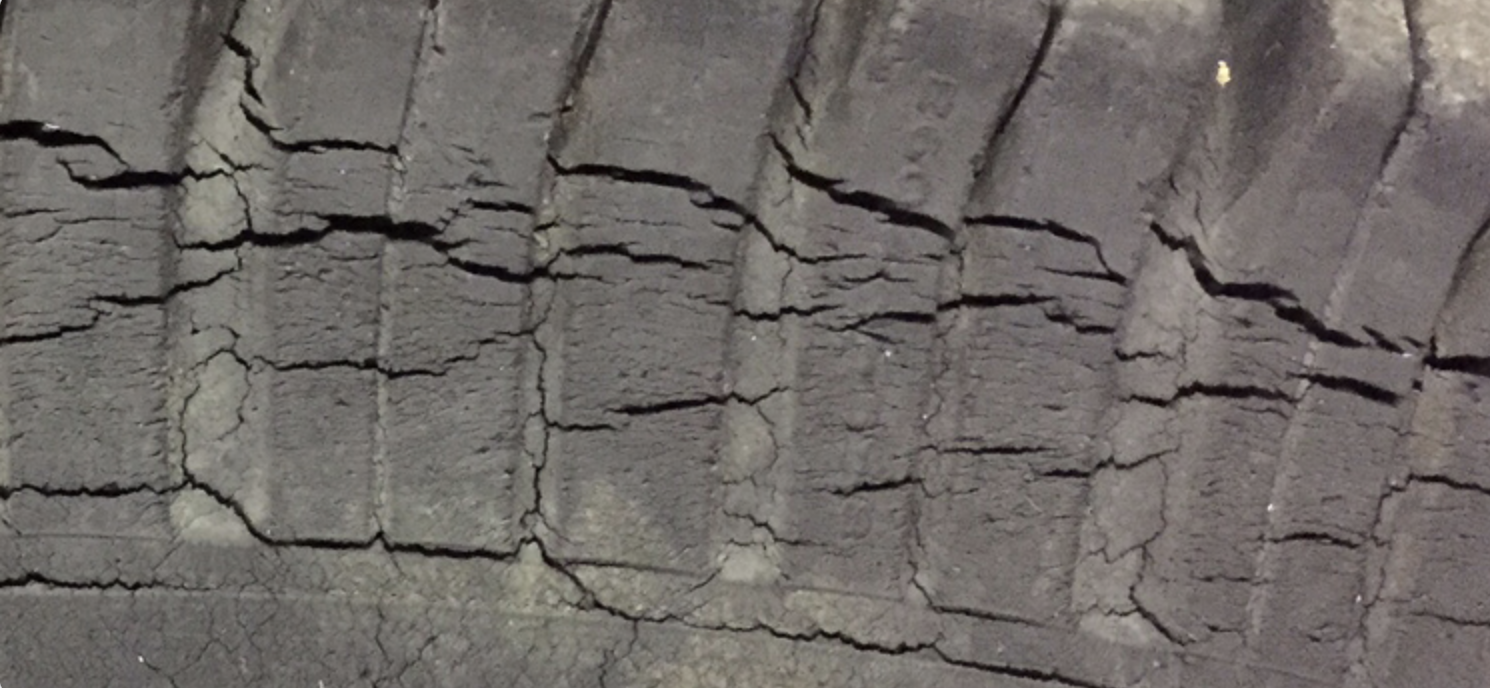

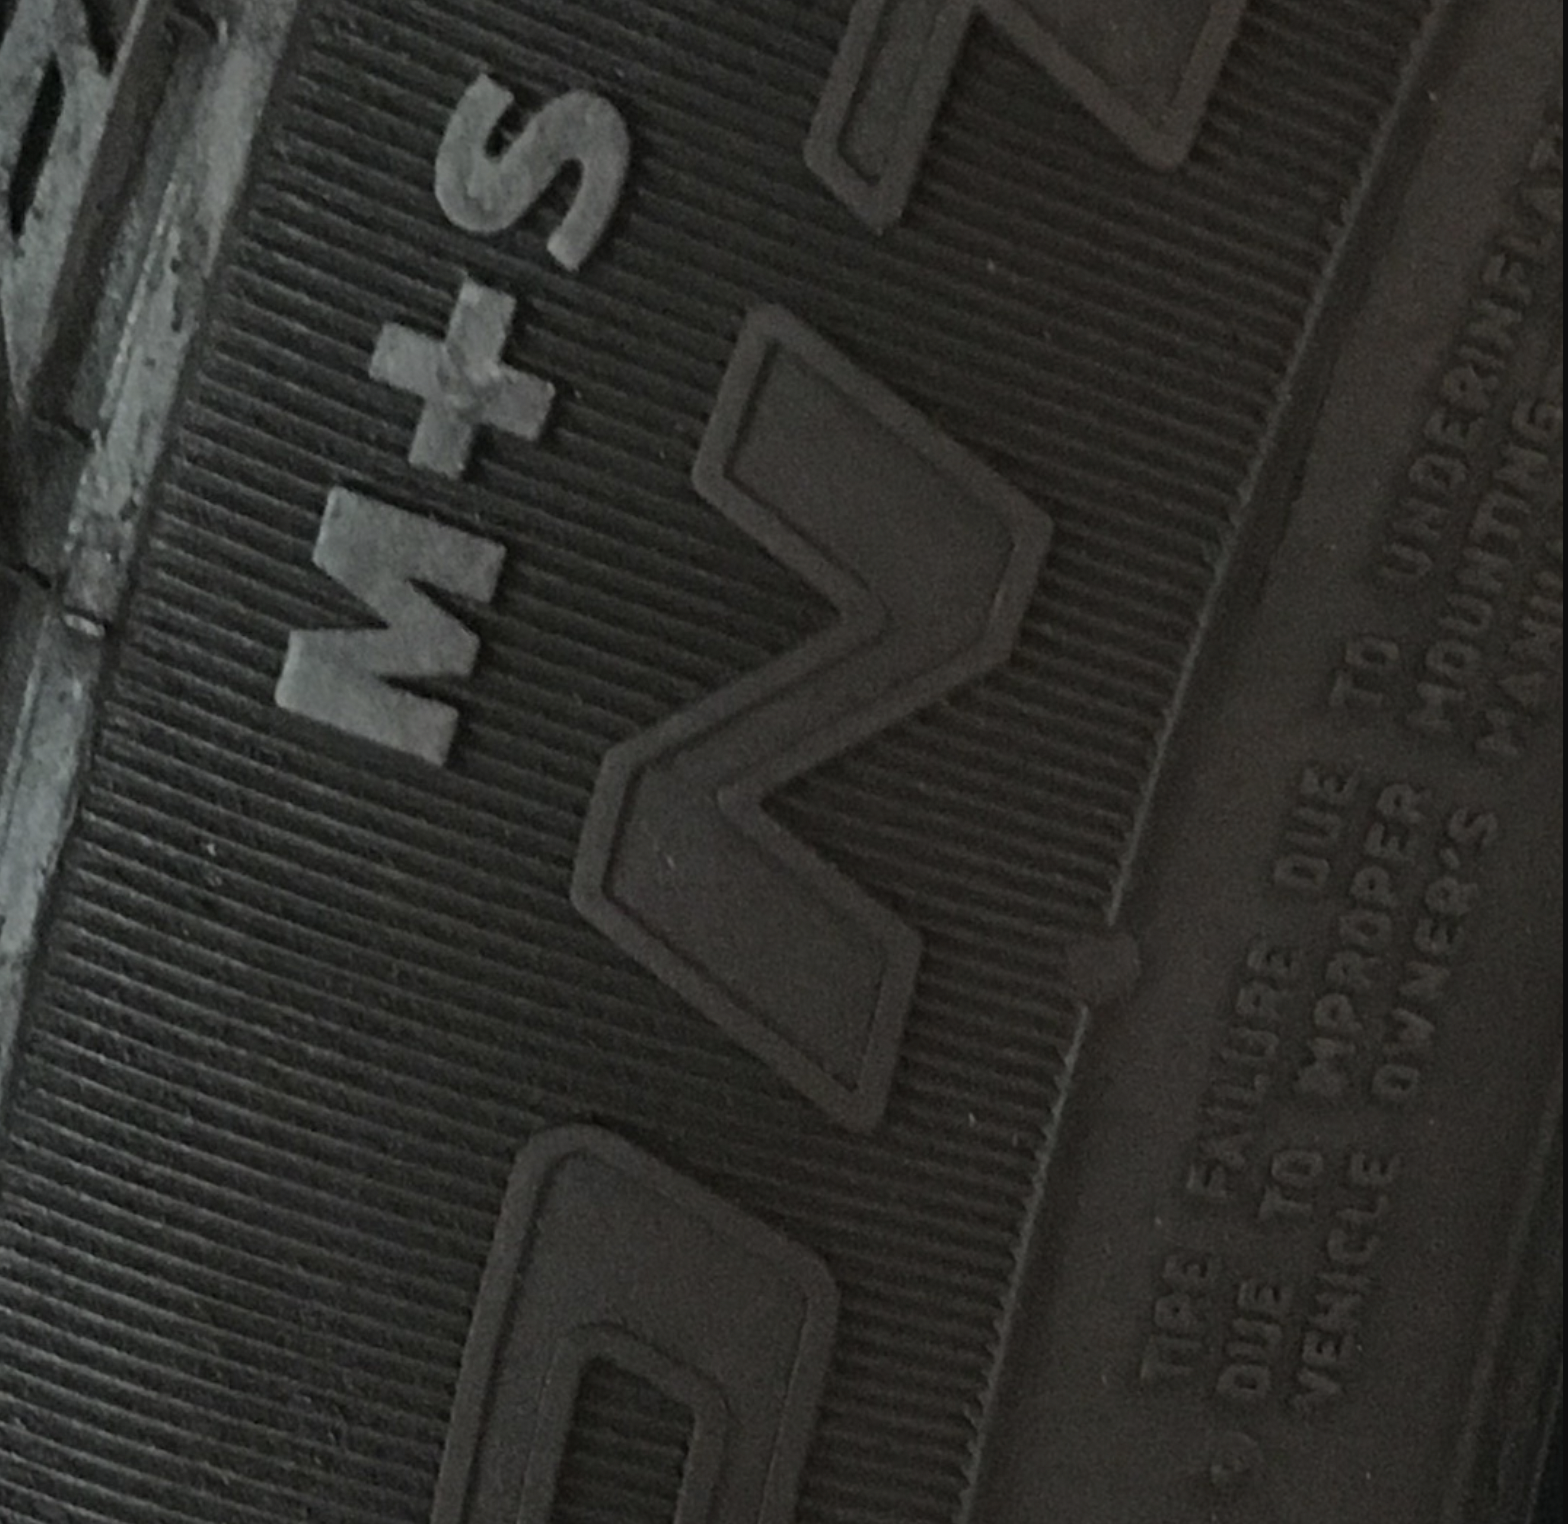

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

### Global Constants

In [59]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 9

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 1
STEPS_PER_EPOCH_VALIDATION = 1

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [60]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [61]:
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

### Define Our Transfer Learning Network Model Consisting of 2 Layers

Here, we are preparing specification or blueprint of the TensorFlow DAG (directed acyclcic graph) for just the MODEL part.

In [62]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# 2nd layer as Dense for 2-class using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer 
model.layers[0].trainable = False

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


### Compile Our Transfer Learning Model

In [64]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

### Prepare Keras Data Generators


In [65]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE


data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = data_generator.flow_from_directory(
        '/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        '/kaggle/input/tire-texture-image-recognition/Tire Textures/testing_data',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 703 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


### Train Our Model With Cats & Dogs Train (splitted) Data Set

In [67]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')


In [68]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("../working/best.hdf5")

Epoch 1/10
1/1 [==============================] - 61s 61s/step - loss: 1.1277 - acc: 0.3300 - val_loss: 1.6624 - val_acc: 0.3500
Epoch 2/10
1/1 [==============================] - 42s 42s/step - loss: 0.7652 - acc: 0.6200 - val_loss: 0.8593 - val_acc: 0.6100
Epoch 3/10
1/1 [==============================] - 42s 42s/step - loss: 0.5830 - acc: 0.7400 - val_loss: 0.5955 - val_acc: 0.7200
Epoch 4/10
1/1 [==============================] - 42s 42s/step - loss: 0.4149 - acc: 0.8200 - val_loss: 0.8587 - val_acc: 0.6500
Epoch 5/10
1/1 [==============================] - 43s 43s/step - loss: 0.3134 - acc: 0.8800 - val_loss: 0.8143 - val_acc: 0.6800
Epoch 6/10
1/1 [==============================] - 25s 25s/step - loss: 0.0589 - acc: 1.0000 - val_loss: 0.7438 - val_acc: 0.7400
Epoch 7/10
1/1 [==============================] - 43s 43s/step - loss: 0.2813 - acc: 0.8700 - val_loss: 0.7465 - val_acc: 0.7500
Epoch 8/10
1/1 [==============================] - 49s 49s/step - loss: 0.2033 - acc: 0.9000 - val

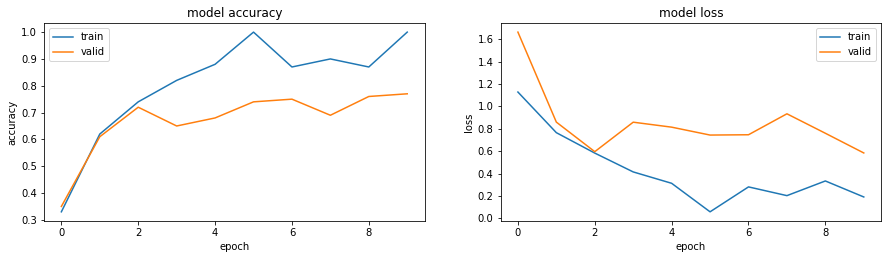

In [69]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

The model gets up to about 80 percent accuracy. We could potentially do better if we unfroze a couple of layers of the nueral network.